In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pyvinecopulib as pv
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [7]:
data = yf.download(["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31") #"GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"

[*********************100%***********************]  6 of 6 completed


In [8]:
data.head()

Adj Close                                                         \
                AAPL     BAS.DE     BMW.DE     DBK.DE       GOOG     RWE.DE   
Date                                                                          
2010-01-04  6.505280  24.106215  19.280518  32.229904  15.610239  39.131069   
2010-01-05  6.516527  23.740725  19.436934  32.749939  15.541497  38.881393   
2010-01-06  6.412875  23.891224  19.737719  32.407471  15.149715  38.807625   
2010-01-07  6.401018  23.732660  19.912176  32.553345  14.797037  38.643055   
2010-01-08  6.443573  23.660101  19.644476  33.739288  14.994298  38.586319   

               Close                                   ...       Open  \
                AAPL     BAS.DE     BMW.DE     DBK.DE  ...     BMW.DE   
Date                                                   ...              
2010-01-04  7.643214  44.849998  32.049999  39.474529  ...  31.820000   
2010-01-05  7.656429  44.169998  32.310001  40.111465  ...  31.959999   
2010-01-06  7.534643  44.450001  32.810001  39.692020  ...  32.450001   
2010-01-07  7.520714  44.154999  33.099998  39.870674  ...  32.650002   
2010-01-08  7.570714  44.020000  32.654999  41.323200  ...  33.334999   

                                                  Volume             \
               DBK.DE       GOOG     RWE.DE         AAPL     BAS.DE   
Date                                                                  
2010-01-04  38.837593  15.615220  68.222816  493729600.0  3245626.0   
2010-01-05  39.381317  15.620949  68.770988  601904800.0  3292371.0   
2010-01-06  39.909512  15.588072  68.202881  552160000.0  2345128.0   
2010-01-07  39.381317  15.178109  67.923813  477131200.0  2505352.0   
2010-01-08  40.740635  14.744733  68.133118  447610800.0  3307737.0   

                                                           
               BMW.DE      DBK.DE         GOOG     RWE.DE  
Date                                                       
2010-01-04  1808170.0   4425924.0   78541293.0  2022078.0  
2010-01-05  1564182.0   5950810.0  120638494.0  2040667.0  
2010-01-06  2218604.0   5818935.0  159744526.0  1535087.0  
2010-01-07  2026145.0   4506202.0  257533695.0  1765257.0  
2010-01-08  1925894.0  10753806.0  189680313.0  1665122.0  

[5 rows x 36 columns]

In [9]:
data = data["Adj Close"]

In [10]:
def logtransform(data):
    data = pd.DataFrame(np.diff(np.log(data[1:]), axis=0), columns=data.columns)
    return data

In [13]:
data = logtransform(data)

In [14]:
data = data.dropna(axis=0)

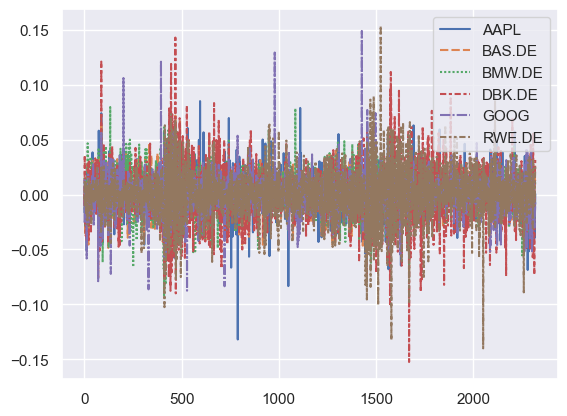

In [15]:
sns.lineplot(data = data);

In [16]:
PF = data.mean(axis=1)

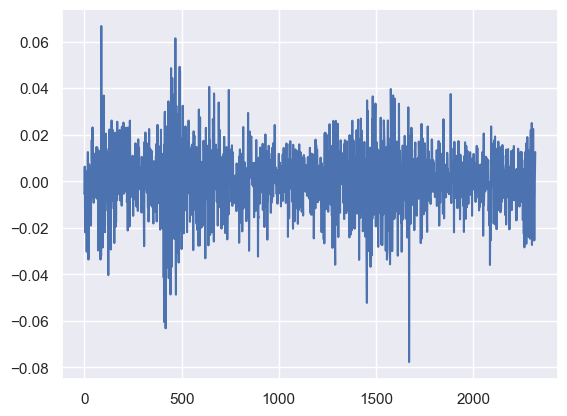

In [17]:
sns.lineplot(x = PF.index, y = PF);

GARCH

Estimate GARCH models for each return series $j=1,...,K$ and $t=1,..,T$

$r_{t,j} = \mu_{t,j}  + \epsilon_{t,j}$

$\epsilon_{t,j} = \sigma_{t,j} Z_{t,j} $


${\sigma_{t,j}}^2 = \omega_j +  \alpha_{k,j} \varepsilon_{t-1,j}^2 + \beta_{k,j} \sigma_{t-1,j}^2$ 

$Z_{t,j}$ as assumed innovation distribution and standardized residuals as 

$\hat{z}_{t,j} = \frac{1}{\hat{\sigma}_{t,j}} \Bigl(  r_{t,j} - \hat{\mu}_j       \Bigr)$


In [ ]:
from arch import arch_model

In [19]:
def fit_model(data):
    am = arch_model(data, vol="Garch", p=1, o=0, q=1, dist="skewt", mean='constant')

    res = am.fit()

    parameters = res.params

    return res



In [21]:
res2 = fit_model(data.AAPL)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 112111.96678951575
Iteration:      2,   Func. Count:     25,   Neg. LLF: 266766.85194092273
Iteration:      3,   Func. Count:     37,   Neg. LLF: 7134.014818341222
Iteration:      4,   Func. Count:     47,   Neg. LLF: -1206.7918888130757
Iteration:      5,   Func. Count:     55,   Neg. LLF: 125123.62617359494
Iteration:      6,   Func. Count:     70,   Neg. LLF: 11063.258952663371
Iteration:      7,   Func. Count:     81,   Neg. LLF: 6488.90426087692
Iteration:      8,   Func. Count:     90,   Neg. LLF: 9604.846617854622
Iteration:      9,   Func. Count:    102,   Neg. LLF: 22277.496888562117
Iteration:     10,   Func. Count:    113,   Neg. LLF: -4355.450401279182
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4355.450400979544
            Iterations: 14
            Function evaluations: 113
            Gradient evaluations: 10


c:\Users\morit\anaconda3\envs\copulagarch\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002625. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [34]:
res2.params

mu           -0.000589
omega         0.001406
alpha[1]      0.584443
beta[1]       0.369503
eta         101.809191
lambda       -0.043305
Name: params, dtype: float64

In [26]:
res2.resid

0      -0.015445
1      -0.001262
2       0.007215
3      -0.008272
4      -0.010851
          ...   
2312    0.013498
2313   -0.031100
2314   -0.024969
2315   -0.039083
2319    0.001101
Name: resid, Length: 2134, dtype: float64

In [13]:
am5 = arch_model(data.AAPL*100, vol="Garch", p=1, o=0, q=1, dist="skewt", mean='constant')

In [14]:
am5.distribution.num_params

2

In [20]:
am5.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 61691.42068508366
Iteration:      2,   Func. Count:     18,   Neg. LLF: 135039.84003182483
Iteration:      3,   Func. Count:     27,   Neg. LLF: 81173.47908621424
Iteration:      4,   Func. Count:     36,   Neg. LLF: 147095.6063738566
Iteration:      5,   Func. Count:     45,   Neg. LLF: 5525.809144590954
Iteration:      6,   Func. Count:     53,   Neg. LLF: 3863.196062792278
Iteration:      7,   Func. Count:     61,   Neg. LLF: 5194.31113095695
Iteration:      8,   Func. Count:     69,   Neg. LLF: 3858.982341343833
Iteration:      9,   Func. Count:     77,   Neg. LLF: 3851.3734042686165
Iteration:     10,   Func. Count:     85,   Neg. LLF: 3851.162105607421
Iteration:     11,   Func. Count:     93,   Neg. LLF: 3851.149772781636
Iteration:     12,   Func. Count:    100,   Neg. LLF: 3851.149615629203
Iteration:     13,   Func. Count:    107,   Neg. LLF: 3851.1496139155324
Iteration:     14,   Func. Count:    113,   Neg. LLF: 3851.149

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                              AAPL   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -3851.15
Distribution:      Standardized Skew Student's t   AIC:                           7714.30
Method:                       Maximum Likelihood   BIC:                           7748.29
                                                   No. Observations:                 2134
Date:                           Sun, Mar 12 2023   Df Residuals:                     2133
Time:                                   16:06:30   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [21]:
am5_fitted = am5.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 61691.42068508366
Iteration:      2,   Func. Count:     18,   Neg. LLF: 135039.84003182483
Iteration:      3,   Func. Count:     27,   Neg. LLF: 81173.47908621424
Iteration:      4,   Func. Count:     36,   Neg. LLF: 147095.6063738566
Iteration:      5,   Func. Count:     45,   Neg. LLF: 5525.809144590954
Iteration:      6,   Func. Count:     53,   Neg. LLF: 3863.196062792278
Iteration:      7,   Func. Count:     61,   Neg. LLF: 5194.31113095695
Iteration:      8,   Func. Count:     69,   Neg. LLF: 3858.982341343833
Iteration:      9,   Func. Count:     77,   Neg. LLF: 3851.3734042686165
Iteration:     10,   Func. Count:     85,   Neg. LLF: 3851.162105607421
Iteration:     11,   Func. Count:     93,   Neg. LLF: 3851.149772781636
Iteration:     12,   Func. Count:    100,   Neg. LLF: 3851.149615629203
Iteration:     13,   Func. Count:    107,   Neg. LLF: 3851.1496139155324
Iteration:     14,   Func. Count:    113,   Neg. LLF: 3851.149

In [22]:
am5_fitted.params

mu          0.101442
omega       0.150627
alpha[1]    0.115299
beta[1]     0.838460
eta         4.398359
lambda     -0.033144
Name: params, dtype: float64

In [27]:
def get_resids_params(returns):
    params = []
    residuals = pd.DataFrame(columns=returns.columns)
    uniform = pd.DataFrame(columns=returns.columns)

    for i in range(0, returns.shape[1]):
        am = arch_model(100*returns.iloc[:, i], vol="Garch", p=1, o=0, q=1, dist="skewt")
        residuals[returns.columns[i]] = am.fit(disp="off").resid / am.fit(disp='off').conditional_volatility
        params.extend([{returns.columns[i]: am.fit(disp="off").params.to_dict()}])
        #uniform[returns.columns[i]] = am.distribution.cdf(residuals, parameters=[5,0.3])#am.fit(disp="off").params["eta"], am.fit(disp="off").params["lambda"]
        #print(am.fit().params["eta"])
        #am.distribution.cdf(residuals, parameters=[5,0.3])


    return params, residuals

In [28]:
get_resids_params(data)

([{'AAPL': {'mu': 0.1014416439253901,
    'omega': 0.1506266412786028,
    'alpha[1]': 0.11529873441545781,
    'beta[1]': 0.8384598586791208,
    'eta': 4.398359354333301,
    'lambda': -0.03314420672820922}},
  {'BAS.DE': {'mu': 0.04558713456485493,
    'omega': 0.027201046240750443,
    'alpha[1]': 0.05727509721895022,
    'beta[1]': 0.9325909568000725,
    'eta': 7.849038428723767,
    'lambda': -0.04867563810640872}},
  {'BMW.DE': {'mu': 0.037012700466833026,
    'omega': 0.009238913142817854,
    'alpha[1]': 0.036975917045191854,
    'beta[1]': 0.9608160848837023,
    'eta': 6.940803068597172,
    'lambda': 0.028259043380350526}},
  {'DBK.DE': {'mu': -0.06391671182725034,
    'omega': 0.05749897474849735,
    'alpha[1]': 0.05109186491473652,
    'beta[1]': 0.9384915030903684,
    'eta': 7.226761485229021,
    'lambda': -0.022056439457213774}},
  {'GOOG': {'mu': 0.057381430777707576,
    'omega': 0.05463304130139145,
    'alpha[1]': 0.03987587204325808,
    'beta[1]': 0.9382364665

In [ ]:
params_

[{'AAPL': {'mu': 0.10144174835471881,
   'omega': 0.15062481053401408,
   'alpha[1]': 0.11529849338093554,
   'beta[1]': 0.8384608393487325,
   'eta': 4.398350222402111,
   'lambda': -0.0331442661039331}},
 {'BAS.DE': {'mu': 0.04558679739719036,
   'omega': 0.027200953073555457,
   'alpha[1]': 0.05727479517227491,
   'beta[1]': 0.9325911673245905,
   'eta': 7.849176578033053,
   'lambda': -0.04867627619633638}},
 {'BMW.DE': {'mu': 0.03701272748723445,
   'omega': 0.009238866713722,
   'alpha[1]': 0.03697591024251973,
   'beta[1]': 0.9608160743717679,
   'eta': 6.940846787454488,
   'lambda': 0.028257901721633217}},
 {'DBK.DE': {'mu': -0.06391674003840897,
   'omega': 0.05749887073303873,
   'alpha[1]': 0.051091808058097224,
   'beta[1]': 0.9384915382410848,
   'eta': 7.226802619951065,
   'lambda': -0.022056888997994226}},
 {'GOOG': {'mu': 0.057381430777707576,
   'omega': 0.05463304130139145,
   'alpha[1]': 0.03987587204325808,
   'beta[1]': 0.9382364665241338,
   'eta': 3.66923636132

In [ ]:
def get_residuals(returns):
    
    params = []
    residuals = pd.DataFrame(columns=returns.columns)
    for i in range(0, returns.shape[1]):
        am = arch_model(100*returns.iloc[:, i], vol="Garch", p=1, o=0, q=1, dist="skewt")
        residuals[returns.columns[i]] = am.fit(disp="off").resid / am.fit(disp='off').conditional_volatility
        params.extend([{returns.columns[i]: am.fit(disp="off").params.to_dict()}])

    return residuals, params

In [ ]:
resids, params = get_residuals(data)

In [ ]:
def get_uniform(returns, resids, params):
    #print(params)
    
    uniform = pd.DataFrame(columns=data.columns)
    for i in range(0, data.shape[1]):
        am = arch_model(vol="Garch", p=1, o=0, q=1, dist="skewt")
        eta_ = params[i][data.columns[i]]['eta']
        lambda_ = params[i][data.columns[i]]['lambda']
        uniform[data.columns[i]] = am.distribution.cdf(data.iloc[:, i], parameters=[eta_, lambda_])

    return uniform.to_numpy()
    #u = am.distribution.cdf(garch_results, parameters=[res.params["eta"], res.params["lambda"]])


In [ ]:
uniform = get_uniform(resids, params)

TypeError: arch_model() missing 1 required positional argument: 'y'

In [ ]:
def simulate_from_vine_copula(data, n = 10000):
    copula = pv.Vinecop(data)
    simulated = copula.simulate(n)
    return simulated

In [ ]:
sims = simulate_from_vine_copula(uniform)

In [ ]:
def transform_to_dist(data):
    am = arch_model(data.AAPL*100, vol="Garch", p=1, o=0, q=1, dist="skewt")
    for i in range(0, data.shape[1]):
        eta_ = params[i][data.columns[i]]['eta']
        lambda_ = params[i][data.columns[i]]['lambda']
        uniform[data.columns[i]] = am.distribution.cdf(data.iloc[:, i], parameters=[eta_, lambda_])

In [ ]:
sims2 = transform_to_dist(sims)

AttributeError: 'numpy.ndarray' object has no attribute 'AAPL'

In [ ]:
len(sims[:,0])

10000

In [ ]:
sims.shape

(10000, 6)